In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.copy2("/content/drive/MyDrive/utilities.py", "/content/utilities.py")
shutil.copy2("/content/drive/MyDrive/ConvNet.py", "/content/ConvNet.py")
shutil.copy2("/content/drive/MyDrive/config.py", "/content/config.py")

'/content/config.py'

In [3]:
import ConvNet
import config
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import numpy as np
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Audio, clear_output, display
from glob import glob
import random
from utilities import acuracia0, acuracia1, acuracia2
import utilities

In [4]:
model = ConvNet.ConvNet

In [ ]:
model.summary()

# EVALUATION



In [5]:

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/aval_morl_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/training_morl_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_morl_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(1.0, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,filenames_ds,classes_n,images_ds,labels_ds

In [9]:
def make_dataset_for_predict(path, batch_size, classes_n):
    def parse_image1(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image
    def parse_image2(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.random_crop(image,size=(40, 256,1))
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    #random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images1 = filenames_ds.map(parse_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images2 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images3 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images4 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images5 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images6 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images7 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images8 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images9 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images10 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images11 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images12 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images13 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images14 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images15 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images16 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images17 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images18 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images19 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images20 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images21 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images22 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images23 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images24 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images25 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images26 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images27 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images28 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images29 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    images30 = filenames_ds.map(parse_image2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images1, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,filenames_ds,images1,images2,images3,images4,images5,images6,images7,images8,images9,images10,images11,images12,images13,images14,images15,images16,images17,images18,images19,images20,images21,images22,images23,images24,images25,images26,images27,images28,images29,images30,labels_ds

In [11]:
trainDS, filenames_train, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, filenames_val, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

In [12]:
list_images_train = list(images_train.as_numpy_iterator())
list_filenames_train = list(filenames_train.as_numpy_iterator())
list_filenames_val = list(filenames_val.as_numpy_iterator())

In [13]:
list_images_validation = list(images_validation.as_numpy_iterator())
list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [14]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [ ]:
for i in range(0,len(list_images_for_predict1)):
    print(list_filenames_test[i], labels_test_true[i])

In [15]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)


print(images_for_predict1.shape)
print(images_for_predict2.shape)
print(images_for_predict3.shape)
print(images_for_predict4.shape)
print(images_for_predict5.shape)


#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8827, 40, 256, 1)
(4670, 40, 256, 1)
(4670, 40, 256, 1)
(4670, 40, 256, 1)
(4670, 40, 256, 1)
(4670, 40, 256, 1)
(4670, 40, 256, 1)
(8827,)
(4670,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [16]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [17]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [18]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        if (acuracia2(labels_validation_true, validation_predictions)) >= 0.875:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Treinamento Interrompido.")
                #self.model.set_weights(self.best_weights)


### Model.fit

In [19]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/138 [>.............................] - ETA: 52s - loss: 5.2521 - accuracy: 0.0130

138/138 [==============================] - 11s 75ms/step
Train - Acurácia 0:  0.1844341225784525
Train - Acurácia 2:  0.6023564064801178
73/73 [==============================] - 7s 99ms/step
Validation - Acurácia 0:  0.10449678800856531
validation - Acurácia 2:  0.4689507494646681
138/138 [==============================] - 97s 588ms/step - loss: 4.2241 - accuracy: 0.1329
Epoch 2/50
138/138 [==============================] - 11s 79ms/step
Train - Acurácia 0:  0.2948906763339753
Train - Acurácia 2:  0.7139458479664665
73/73 [==============================] - 6s 78ms/step
Validation - Acurácia 0:  0.15631691648822268
validation - Acurácia 2:  0.6079229122055675
138/138 [==============================] - 78s 566ms/step - loss: 3.0605 - accuracy: 0.2799
Epoch 3/50
138/138 [==============================] - 11s 78ms/step
Train - Acurácia 0:  0.33896000906310186
Train - Acurácia 2:  0.7624334428458139
73/73 [==============================] - 6s 78ms/step
Validation - Acurácia 0:  0.1843683083

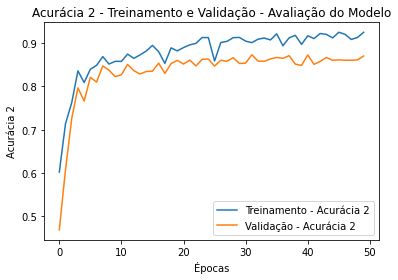

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - Avaliação do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/morl_40_aval/acc2_'+'aval'+'.pdf', format='pdf')
plt.show()

In [21]:
np.save('/content/drive/MyDrive/Resultados/morl_40_aval/acc2_'+'aval',acc)
np.save('/content/drive/MyDrive/Resultados/morl_40_aval/val_acc2_'+'aval',val_acc)

In [22]:
model.save('/content/drive/MyDrive/Resultados/morl_40_aval/morl_40_aval')

In [7]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/morl_40_aval/morl_40_aval')

### Training Results

In [23]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

138/138 [==============================] - 11s 77ms/step
(8827, 140)
(8827,)
(8827,)


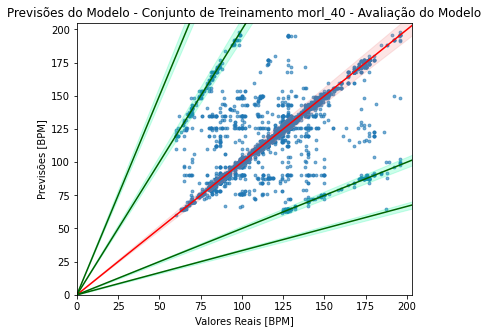

In [24]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento morl_40 - Avaliação do Modelo', '/content/drive/MyDrive/Resultados/morl_40_aval/prev_train_'+'aval'+'.pdf')

In [25]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_morl_40_aval_da1'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

              Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_morl_40_aval_da1    0.542767    0.891469      0.92489


### Validation Results

In [26]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 6s 78ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


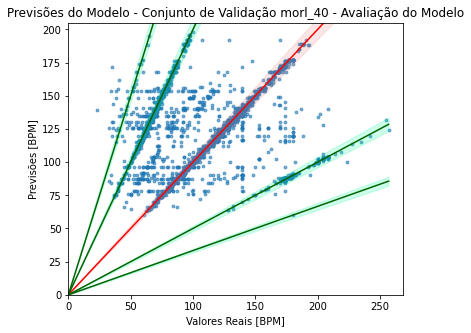

In [27]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação morl_40 - Avaliação do Modelo', '/content/drive/MyDrive/Resultados/morl_40_aval/prev_validation_'+'aval'+'.pdf')

In [28]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_morl_40_aval_da1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

                   Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_morl_40_aval_da1    0.542767    0.891469     0.924890
1  validation_morl_40_aval_da1    0.290578    0.629979     0.870236


In [29]:
resultados.to_excel("/content/drive/MyDrive/Resultados/morl_40_aval/Resultados_morl_40_aval.xlsx", index=False)  

In [ ]:
from google.colab import runtime
runtime.unassign()

### Test PREDICT Windows

In [30]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)



73/73 [==============================] - 6s 78ms/step


In [ ]:
test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

In [32]:
print(test_predictions.shape)

(4670,)


In [33]:
print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

0.30149892933618844
0.6496788008565311
0.892933618843683


ACM_MIRUM

In [11]:
VAL_DATASET = os.path.join("/content", "ACM_MIRUM")
testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)


In [12]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)

experimento = 'aval_morl_40_aval_ACM_MIRUM'
resultados_aval = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])


23/23 [==============================] - 2s 73ms/step
[ 75 151  75  75 151  75  75 151 151  75 151 151  75  75 151 151  75  75
 151 151  75  75 151 151  75  75  75 151 151 151] 75 38
[ 88 143  88  88  88  88  88  88  88 176 176 144  88  88  88  88 176 176
 144  88  88  88 176 176  88 176  88  88 176 176] 88 176
[176 176  88 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176  88 176 176 176 176] 176 176
[80 80 81 80 81 81 80 81 81 81 80 80 80 81 80 80 80 81 80 80 81 80 80 81
 81 80 80 80 81 80] 80 40
[155  78 154 156  78 156  78 154 154  78 154 154 156  78 156  78  78  78
  78 154  78  78 154 155 156  78 155 154 156 154] 78 40
[ 84  83  84 168  83  84  84  83  83  84  84  84  84  84  84  84  83 168
  84  84  84 168  84  84 168  83 168  84  84  83] 84 40
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 106
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106

BALLROOM

In [13]:
VAL_DATASET = os.path.join("/content", "BALLROOM1")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [15]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)



experimento = 'aval_morl_40_aval_BALLROOM'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

11/11 [==============================] - 1s 75ms/step
[106 106 106 106 106 106 106 106 106 106 106 106 106 104 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 214
[176 176 176 176 176 176 176 176 176 176 176 176 176 176  88 176 176 176
  88  88  88 176 176 176 176 176 176 176  88  88] 176 176
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176] 176 176
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176] 176 176
[ 88  88  88 176 176  88 176  88  88 176  88  88 176  88 176  88  88  88
  88  88  88  88  88  88  88  88 176 176  88 176] 88 176
[ 88  88  88  88 176  88  88 176 176 176 176 176  88  88  88  88  88 176
  88 176  88  88  88  88  88 176  88 176  88  88] 88 176
[176 176  88  88 176  88  88 176 176 176 176 176  88 176  88 176 176 176
 176 176  88 176 176 176 176  88 176  88 176 176] 176 176
[ 88 176 176  88 176  88 176  8

GIANTSTEPS

In [16]:
VAL_DATASET = os.path.join("/content", "GIANTSTEPS")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [17]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)


experimento = 'aval_morl_40_aval_GIANTSTEPS'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

11/11 [==============================] - 1s 75ms/step
[106 107 106 106 140 106 106 106 106 140 106 107 106 106 106 106 107 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 106
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 106
[ 92 104 126  92  90 104  92  90  90 104 104 104  92  92  90  90 104  92
  92  92 104  92  92  92 104 104 104 104 126 126] 92 92
[140 141 140 140 141 141 140 140 140 141 140 140 141 140 140 141 140 140
 140 141 141  72 140 141 141 141 141 140 141 141] 140 140
[140 141 140  90 141 140 141 140 140 141 141 140 140 141 140 140 140 140
 140 141 141 141 140 141 140 140 141 140 140 126] 140 140
[140 140 141 141 141 140 141 140 140 140 140 140 141 140 140 140 141 140
 140 140 140 140 141 140 140 140 140 140 140 140] 140 140
[140 141 141 140 140 139 140 141 141 140 140 140 143 140 140 140 126 141
 141 141 140 141 140 140 143 140 139 140 140 143] 140 140
[138 140  90 120 138 141 138 13

GTZAN_GENRES

In [18]:
VAL_DATASET = os.path.join("/content", "GTZAN_GENRES")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [19]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)


experimento = 'aval_morl_40_aval_GTZAN_GENRES'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

16/16 [==============================] - 1s 76ms/step
[ 76  75  75  75 112  75  75 112 112 112 112  76 112 112  75  76  75  75
  76  75 112  75 112 112  75  75  75  76  76 112] 75 38
[75 76 76 76 75 75 75 75 75 76 76 75 75 75 75 75 75 75 76 76 76 76 76 75
 76 76 75 75 76 75] 75 38
[124 156 122 149 154 148 156 148 148 148 149 154 154 150 154 148 149 155
 148 148 155 156 148 148 154 122 150 149 148 148] 148 38
[154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154
 154 154 154 154 154 154 154 154 154 154 154 154] 154 38
[126  90  90 141  90  96  90  90  90  90 126 141  90  90 141 126  90 126
  90 141 141  90 141  90  90  90  90 126  90 126] 90 40
[78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78
 78 78 78 78 78 79] 78 40
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 106
[157 104 158 160 104 104 104 104 104 104 104 157 104 104 108 157 157 104
 104 104 104 104 104 104 1

HAINSWORTH

In [20]:
VAL_DATASET = os.path.join("/content", "HAINSWORTH")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [21]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)

experimento = 'aval_morl_40_aval_HAINSWORTH'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

4/4 [==============================] - 0s 73ms/step
[104 104 104 104 106 106 104 104 104 106 104 110 104 104 110 104 104 108
 106 104 109 110 104 110 106 104 104 104 106 106] 104 106
[104 106 106 106 106 106 106 104 104 104 108 104 106 106 104 106 104 106
 106 106 104 108 106 104 106 106 106 106 106 104] 106 105
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 104 106 106 106 104 104 104 104 106 106 106 106] 106 105
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 105
[180  94  90  90  90  94  90 192 192  90 180 192  90  90  94 124 188  90
  94  90 189 180 192  90 148 188  90  90 180 189] 90 92
[92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92] 92 92
[ 92 189 189 189  92 189  92  92  92 189 189 155  92  92  94  92  92  92
 189  92 155 189  92  92  94 189  94 189 189 189] 92 92
[92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 

ISMIR2004


In [22]:
VAL_DATASET = os.path.join("/content", "ISMIR2004")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [23]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)

experimento = 'aval_morl_40_aval_ISMIR2004'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

8/8 [==============================] - 1s 75ms/step
[148 144 148 143 128 126 128 144 144 128 143 148 128 141 143 128 128 128
 144 148 126 148 143 143 128 148 148 128 143 128] 128 38
[115 115 115 115 154 120 120 115 115 116 154 115 154 120 115 115 120 115
 115 120 116 120 115 116 115 154 120 115 128 115] 115 38
[104 104 108 108 106 106 106 108 108 106 108 106 108 106 106 104 104 104
 106 106 104 108 104 106 104 108 106 104 104 106] 106 106
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 106
[108 106 106 106 108 108 108 108 108 108 108 108 106 108 108 108 108 108
 108 108 106 108 108 108 108 108 108 108 106 108] 108 106
[106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106
 106 106 106 106 106 106 106 106 106 106 106 106] 106 106
[106 106 106 106 106 106 106 106 106 126 126 106 106 106 106 106 106 106
 110 106 106 106 106 106 106 106 106 106 106 126] 106 106
[100 148 100 148 148 132 148 132 

SMC_MIRUM

In [24]:
VAL_DATASET = os.path.join("/content", "SMC_MIRUM")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [25]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)


experimento = 'aval_morl_40_aval_SMC_MIRUM'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

4/4 [==============================] - 0s 73ms/step
[ 86 104  87 104  86  87  96 104 104  96  87  96 104  87  87  96  87  87
  90  96  96  96  86  96  96  86  87 104  87  96] 96 33
[126 124 124  92 124 126 126 135 135 126 126 126 126 126 126  96  96 126
 126  92 126 130 126 126 126 124  96 112 126  90] 126 33
[ 78 154  81  84  84  84  96 135 135 112  78  78 154  88  90  90  78  88
 112  78  81 130 112  88  84  76 135  90  90  78] 78 40
[ 81  80 126 135 154 154 120  80  80  81 148  84 154 154  80 154  80 154
 154  96 154 126  96 154 120 126 126  84  90  96] 154 40
[80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80
 80 80 80 80 80 80] 80 40
[104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104
 104 104 104 104 104 104 104 104 104 104 104 104] 104 105
[ 87  87 117  87 117 115 102 110 110  90  87 110 115  87 130 115 117  87
 112  92  87  90  87 110  87 117 110  87 110 110] 87 92
[92 92 92 92 96 92 92 92 92 86 90 87 96 96 96 92 92 92 90 92 92 92 92 9

COMBINADOS

In [26]:
VAL_DATASET = os.path.join("/content", "COMBINADOS")

testDS, classes_test, filenames_test, images_test1, images_test2, images_test3, images_test4, images_test5, images_test6,images_test7,images_test8,images_test9,images_test10,images_test11,images_test12,images_test13,images_test14,images_test15,images_test16,images_test17,images_test18,images_test19,images_test20,images_test21,images_test22,images_test23,images_test24,images_test25,images_test26,images_test27,images_test28,images_test29,images_test30,labels_test = make_dataset_for_predict(VAL_DATASET, config.BS, classes_val)

list_images_for_predict1 = list(images_test1.as_numpy_iterator())
list_images_for_predict2 = list(images_test2.as_numpy_iterator())
list_images_for_predict3 = list(images_test3.as_numpy_iterator())
list_images_for_predict4 = list(images_test4.as_numpy_iterator())
list_images_for_predict5 = list(images_test5.as_numpy_iterator())
list_images_for_predict6 = list(images_test6.as_numpy_iterator())
list_images_for_predict7 = list(images_test7.as_numpy_iterator())
list_images_for_predict8 = list(images_test8.as_numpy_iterator())
list_images_for_predict9 = list(images_test9.as_numpy_iterator())
list_images_for_predict10 = list(images_test10.as_numpy_iterator())
list_images_for_predict11 = list(images_test11.as_numpy_iterator())
list_images_for_predict12 = list(images_test12.as_numpy_iterator())
list_images_for_predict13 = list(images_test13.as_numpy_iterator())
list_images_for_predict14 = list(images_test14.as_numpy_iterator())
list_images_for_predict15 = list(images_test15.as_numpy_iterator())
list_images_for_predict16 = list(images_test16.as_numpy_iterator())
list_images_for_predict17 = list(images_test17.as_numpy_iterator())
list_images_for_predict18 = list(images_test18.as_numpy_iterator())
list_images_for_predict19 = list(images_test19.as_numpy_iterator())
list_images_for_predict20 = list(images_test20.as_numpy_iterator())
list_images_for_predict21 = list(images_test21.as_numpy_iterator())
list_images_for_predict22 = list(images_test22.as_numpy_iterator())
list_images_for_predict23 = list(images_test23.as_numpy_iterator())
list_images_for_predict24 = list(images_test24.as_numpy_iterator())
list_images_for_predict25 = list(images_test25.as_numpy_iterator())
list_images_for_predict26 = list(images_test26.as_numpy_iterator())
list_images_for_predict27 = list(images_test27.as_numpy_iterator())
list_images_for_predict28 = list(images_test28.as_numpy_iterator())
list_images_for_predict29 = list(images_test29.as_numpy_iterator())
list_images_for_predict30 = list(images_test30.as_numpy_iterator())
list_filenames_test = list(filenames_test.as_numpy_iterator())

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes_val[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

images_for_predict1 = np.array(list_images_for_predict1)
images_for_predict2 = np.array(list_images_for_predict2)
images_for_predict3 = np.array(list_images_for_predict3)
images_for_predict4 = np.array(list_images_for_predict4)
images_for_predict5 = np.array(list_images_for_predict5)
images_for_predict6 = np.array(list_images_for_predict6)
images_for_predict7 = np.array(list_images_for_predict7)
images_for_predict8 = np.array(list_images_for_predict8)
images_for_predict9 = np.array(list_images_for_predict9)
images_for_predict10 = np.array(list_images_for_predict10)
images_for_predict11 = np.array(list_images_for_predict11)
images_for_predict12 = np.array(list_images_for_predict12)
images_for_predict13 = np.array(list_images_for_predict13)
images_for_predict14 = np.array(list_images_for_predict14)
images_for_predict15 = np.array(list_images_for_predict15)
images_for_predict16 = np.array(list_images_for_predict16)
images_for_predict17 = np.array(list_images_for_predict17)
images_for_predict18 = np.array(list_images_for_predict18)
images_for_predict19 = np.array(list_images_for_predict19)
images_for_predict20 = np.array(list_images_for_predict20)
images_for_predict21 = np.array(list_images_for_predict21)
images_for_predict22 = np.array(list_images_for_predict22)
images_for_predict23 = np.array(list_images_for_predict23)
images_for_predict24 = np.array(list_images_for_predict24)
images_for_predict25 = np.array(list_images_for_predict25)
images_for_predict26 = np.array(list_images_for_predict26)
images_for_predict27 = np.array(list_images_for_predict27)
images_for_predict28 = np.array(list_images_for_predict28)
images_for_predict29 = np.array(list_images_for_predict29)
images_for_predict30 = np.array(list_images_for_predict30)

In [27]:
def predict(images_for_predict, BS):
    num_images_val = len(images_for_predict)
    validation_steps = math.ceil(num_images_val/BS)
    val_predictions = model.predict(images_for_predict, batch_size=BS, steps=validation_steps, verbose=1)
    arg_max = np.argmax(val_predictions, axis=1)
    shape = val_predictions.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if (j==arg_max[i]):
                val_predictions[i][j]=1
            else:
                val_predictions[i][j]=0
    mlb = MultiLabelBinarizer()
    dicionario = mlb.fit_transform([classes])
    val_pred_new = mlb.inverse_transform(val_predictions)
    val_pred_new = np.array(val_pred_new, int)
    val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))
    return val_pred_new




test_predict_1 = predict(images_for_predict1, config.BS)
test_predict_2 = predict(images_for_predict2, config.BS)
test_predict_3 = predict(images_for_predict3, config.BS)
test_predict_4 = predict(images_for_predict4, config.BS)
test_predict_5 = predict(images_for_predict5, config.BS)
test_predict_6 = predict(images_for_predict6, config.BS)
test_predict_7 = predict(images_for_predict7, config.BS)
test_predict_8 = predict(images_for_predict8, config.BS)
test_predict_9 = predict(images_for_predict9, config.BS)
test_predict_10 = predict(images_for_predict10, config.BS)
test_predict_11 = predict(images_for_predict11, config.BS)
test_predict_12 = predict(images_for_predict12, config.BS)
test_predict_13 = predict(images_for_predict13, config.BS)
test_predict_14 = predict(images_for_predict14, config.BS)
test_predict_15 = predict(images_for_predict15, config.BS)
test_predict_16 = predict(images_for_predict16, config.BS)
test_predict_17 = predict(images_for_predict17, config.BS)
test_predict_18 = predict(images_for_predict18, config.BS)
test_predict_19 = predict(images_for_predict19, config.BS)
test_predict_20 = predict(images_for_predict20, config.BS)
test_predict_21 = predict(images_for_predict21, config.BS)
test_predict_22 = predict(images_for_predict22, config.BS)
test_predict_23 = predict(images_for_predict23, config.BS)
test_predict_24 = predict(images_for_predict24, config.BS)
test_predict_25 = predict(images_for_predict25, config.BS)
test_predict_26 = predict(images_for_predict26, config.BS)
test_predict_27 = predict(images_for_predict27, config.BS)
test_predict_28 = predict(images_for_predict28, config.BS)
test_predict_29 = predict(images_for_predict29, config.BS)
test_predict_30 = predict(images_for_predict30, config.BS)

test_predictions = []
for i in range(0,len(test_predict_1)):
    list1 = [test_predict_1[i], test_predict_2[i], test_predict_3[i], test_predict_4[i], test_predict_5[i], test_predict_6[i], test_predict_7[i], test_predict_8[i], test_predict_8[i], test_predict_10[i],
             test_predict_11[i], test_predict_12[i], test_predict_13[i], test_predict_14[i], test_predict_15[i], test_predict_16[i], test_predict_17[i], test_predict_18[i], test_predict_19[i], test_predict_20[i],
             test_predict_21[i], test_predict_22[i], test_predict_23[i], test_predict_24[i], test_predict_25[i], test_predict_26[i], test_predict_27[i], test_predict_28[i], test_predict_29[i], test_predict_30[i]]
    list1 = np.array(list1)
    counts = np.bincount(list1)
    print(list1, np.argmax(counts), labels_test_true[i])
    test_predictions.append(np.argmax(counts))
    
    #print(val_pred_new1[i], val_pred_new2[i],val_pred_new3[i],val_pred_new4[i],val_pred_new5[i],labels_test_true[i], list_filenames_test[i])
test_predictions = np.array(test_predictions)
print(test_predictions)

print(utilities.acuracia0(labels_test_true, test_predictions))
print(utilities.acuracia1(labels_test_true, test_predictions))
print(utilities.acuracia2(labels_test_true, test_predictions))

acc0 = utilities.acuracia0(labels_test_true, test_predictions)
acc1 = utilities.acuracia1(labels_test_true, test_predictions)
acc2 = utilities.acuracia2(labels_test_true, test_predictions)

experimento = 'aval_morl_40_aval_COMBINADOS'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados_aval = resultados_aval.append(newline, ignore_index=True)

A saída de streaming foi truncada nas últimas 5000 linhas.
[135 135 135  84 135  84  84 135 135  84 135 135  84  84  90 126 135 135
 135 126 135 135 135  90 135  84 135  84  87  84] 135 41
[124 122 124 122 122 122 124 122 122 124 124 122 122 122 122 123 123 124
 122 122 124 123 122 124 124 122 122 122 124 122] 122 41
[162 168  83  81  83  81  81  84  84  84  83  83  84  81  83  81  81  83
  81 168  83  84  84  83  84  81  83  81  84  83] 83 41
[ 83  83 168 165  83  83 165  83  83 165 165  83  83 165 168  83 165 168
 168  83  83  83 168 168 165  83 168  83 165 165] 83 41
[ 84  84  84  84 110  84  84  84  84  84  84  84  84 110 110  84  84  84
  84  84  84  84  84  84  84  84  84  84 110  84] 84 41
[122 122 122 123 122 122 122 122 122 122 122 122 123 122 122 122 122 122
 122 122 122 122 122 122 122 122 122 122 122 122] 122 123
[123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123] 123 123
[122 122 122 122 122 122 122 122

In [ ]:
resultados_aval.to_excel("/content/drive/MyDrive/Resultados/morl_40_aval/Resultados_aval_morl_40_aval.xlsx", index=False)  

In [ ]:
from google.colab import runtime
runtime.unassign()